In [61]:
from numba import *
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from PIL.Image import ANTIALIAS
from os import listdir
from scipy.ndimage import correlate

In [2]:
@jit
def DoG_norm_CPU(img_out, img_in, image_size, win_size):

    sumation = .0001
    for idx in range(img_in.shape[0]):
        for idy in range(img_in.shape[1]):
            j = 0 if idy-win_size < 0 else idy-win_size
            while j <= (image_size[1]-1 if idy+win_size > image_size[1]-1 else idy+win_size):
                i = 0 if idx - win_size < 0 else idx - win_size
                while i <= (image_size[0]-1 if idx+win_size > image_size[0]-1 else idx+win_size):
                    sumation += img_in[i, j]
                    i += 1
                j += 1
            mean = sumation / ((2*win_size+1)**2)
            img_out[idx, idy] = img_in[idx, idy] / mean
    return img_out

In [64]:
def DoG(size, s1, s2):
    """
        Generates a filter window of size size x size with std of s1 and s2
    """
    r = np.arange(size)+1
    x = np.tile(r, [size, 1])
    y = x.T
    d2 = (x-size/2.-0.5)**2 + (y-size/2.-0.5)**2
    filt = 1/np.sqrt(2*np.pi) * (1/s1 * np.exp(-d2/(2*(s1**2))) - 1/s2 * np.exp(-d2/(2*(s2**2))))
    filt -= np.mean(filt[:])
    filt /= np.amax(filt[:])
    return filt

In [72]:
filt = DoG(7, 1,2)
total_time = 15
num_layers = 6

In [19]:
TRAIN_PATH = "../datasets/TrainingSet/Face"

In [25]:
listdir("../datasets/TrainingSet/Face")

['image_0001.jpg',
 'image_0005.jpg',
 'image_0009.jpg',
 'image_0011.jpg',
 'image_0012.jpg',
 'image_0014.jpg',
 'image_0020.jpg',
 'image_0025.jpg',
 'image_0027.jpg',
 'image_0029.jpg',
 'image_0031.jpg',
 'image_0034.jpg',
 'image_0038.jpg',
 'image_0040.jpg',
 'image_0045.jpg',
 'image_0047.jpg',
 'image_0049.jpg',
 'image_0051.jpg',
 'image_0053.jpg',
 'image_0055.jpg',
 'image_0056.jpg',
 'image_0058.jpg',
 'image_0060.jpg',
 'image_0062.jpg',
 'image_0064.jpg',
 'image_0066.jpg',
 'image_0067.jpg',
 'image_0069.jpg',
 'image_0073.jpg',
 'image_0075.jpg',
 'image_0077.jpg',
 'image_0078.jpg',
 'image_0080.jpg',
 'image_0082.jpg',
 'image_0084.jpg',
 'image_0086.jpg',
 'image_0088.jpg',
 'image_0089.jpg',
 'image_0091.jpg',
 'image_0093.jpg',
 'image_0095.jpg',
 'image_0097.jpg',
 'image_0099.jpg',
 'image_0100.jpg',
 'image_0102.jpg',
 'image_0106.jpg',
 'image_0108.jpg',
 'image_0110.jpg',
 'image_0111.jpg',
 'image_0113.jpg',
 'image_0115.jpg',
 'image_0117.jpg',
 'image_0122

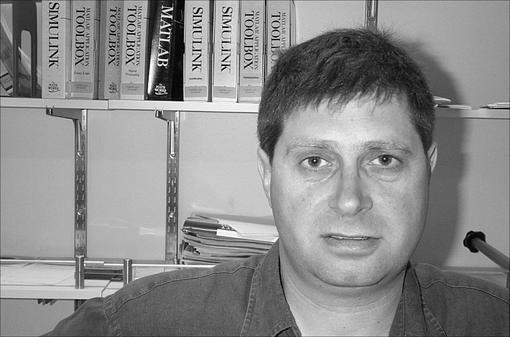

In [26]:
Image.open("../datasets/TrainingSet/Face/image_0001.jpg")

In [57]:
img = Image.open(TRAIN_PATH+"/image_"+("%04d" % 1)+".jpg")
img = img.convert("L")
img_size = img.size
img = np.asarray(img.getdata(),dtype=np.float64).reshape((img_size[1],img_size[0]))

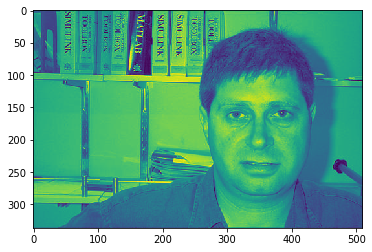

In [60]:
plt.imshow(img)
plt.show()

In [73]:
img = correlate(img, filt, mode='constant')

# Border
border = np.zeros(img.shape)
border[5:-5, 5:-5] = 1.
img = img * border

# Threshold
img = (img >= 15).astype(int) * img
img = np.abs(img)  # Convert -0. to 0.

# DoG Normalization
# img_out = DoG_normalization(img)
# img_out = DoG_normalization_CPU(img)
img_out = img

# Convert to spike times
I = np.argsort(1 / img_out.flatten())  # Get indices of sorted latencies
lat = np.sort(1 / img_out.flatten())  # Get sorted latencies
I = np.delete(I, np.where(lat == np.inf))  # Remove infinite latencies indexes
II = np.unravel_index(I, img_out.shape)  # Get the row, column and depth of the latencies in order
t_step = np.ceil(np.arange(I.size) / ((I.size) / (total_time - num_layers))).astype(np.uint8)
II += (t_step,)
spike_times = np.zeros((img_out.shape[0], img_out.shape[1], total_time))
spike_times[II] = 1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


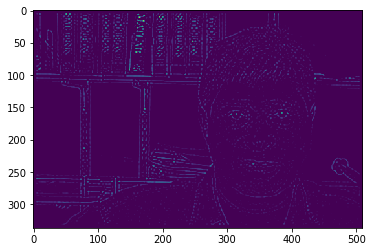

In [75]:
plt.imshow(img_out)
plt.show()

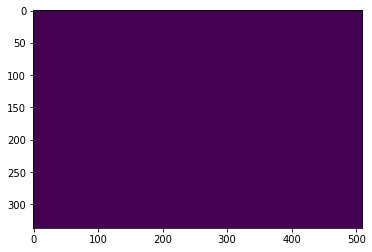

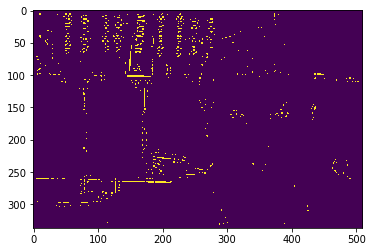

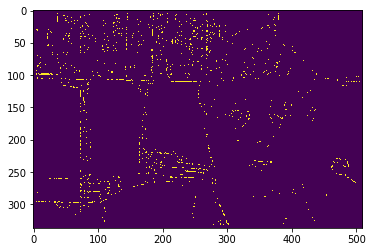

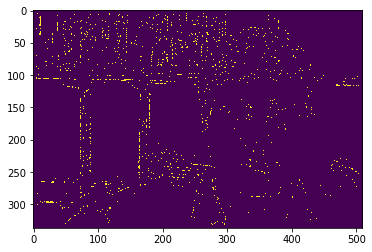

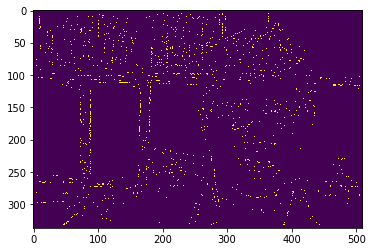

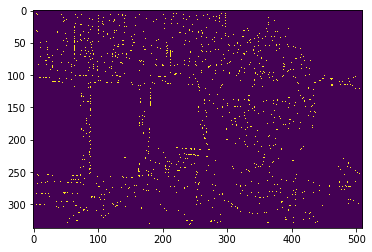

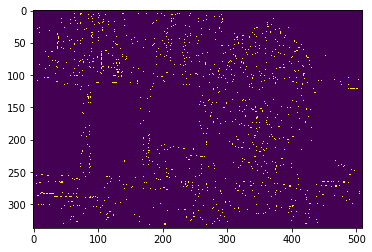

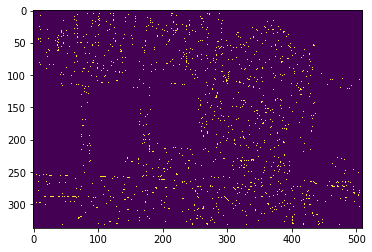

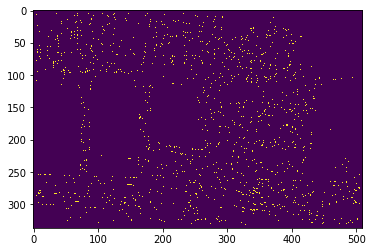

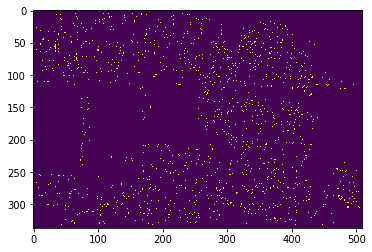

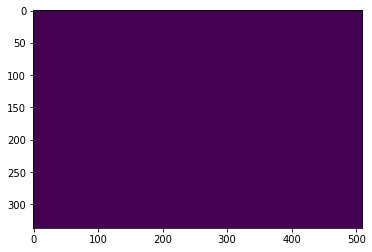

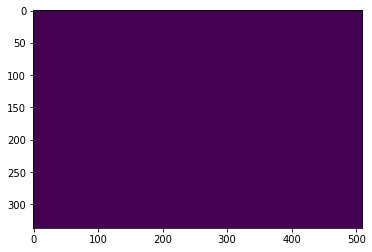

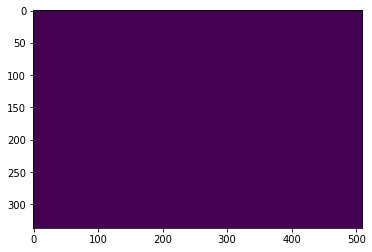

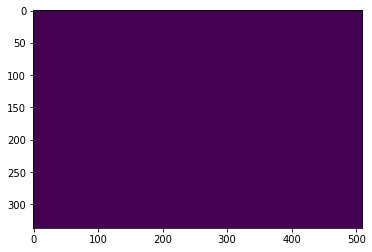

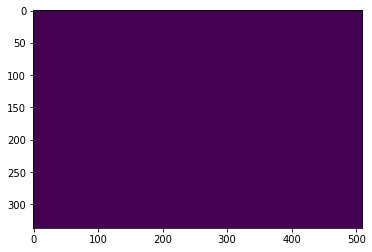

In [83]:
for t in range(total_time):
    time_slice = np.array(spike_times[:,:,t])
    time_slice *= 255
    plt.imshow(time_slice)
    plt.show()